In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import pdb
import copy
import math

from FlowModels import *
from SOBI import *

from sklearn import cluster, datasets, mixture

import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

%matplotlib inline

### Nonlinear ICA

In [2]:
import scipy as sp
from scipy import signal

np.random.seed(0)
n_samples = 4000
time = np.linspace(0, 8, n_samples)

s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal

irregular_time = [0]
for _ in time[1:]:
    irregular_time.append(irregular_time[-1] + np.random.randint(5) + 1)
    
irregular_time = np.array(irregular_time) / n_samples * 8

s2 = np.sign(np.sin(3 * irregular_time))  # Signal 2 : square signal

irregular_time = [0]
for _ in time[1:]:
    irregular_time.append(irregular_time[-1] + np.random.randint(5) + 1)
    
irregular_time = np.array(irregular_time) / n_samples * 8

s3 = signal.sawtooth(2 * np.pi * irregular_time)  # Signal 3: saw tooth signal
s4 = np.arange(-1, 1, 2/n_samples)

S = np.c_[s1, s2, s3, s4]
S += 0.2 * np.random.normal(size=S.shape)  # Add noise

S /= S.std(axis=0)  # Standardize data
S = (S - S.min(axis=0, keepdims=True)) / (S.max(axis=0, keepdims=True) - S.min(axis=0, keepdims=True))  # Standardize data
# Mix data
A = np.array([[1, 1, 1, 1], [0.5, 2, 1.0, 0.5], [1.5, 1.0, 2.0, 1.5], [-0.5, 1, 0.2, 0.5]])  # Mixing matrix
X = np.dot(S, A.T)  # Generate observations

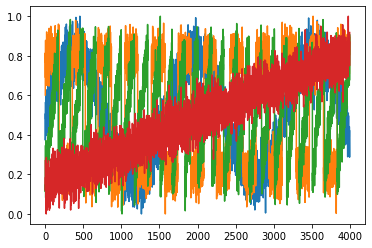

In [3]:
plt.plot(S);

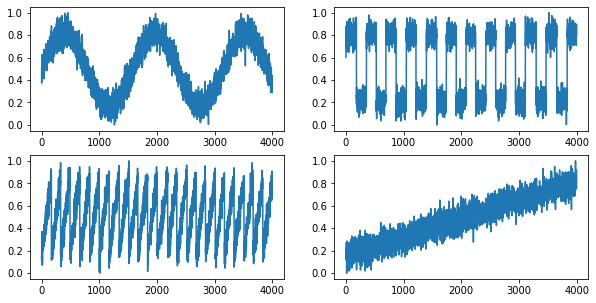

In [12]:
plt.figure(figsize=(10,5))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(S[:, i])

In [5]:
D = 4
NN = lambda: nn.Sequential(nn.Linear(D//2, D))

mixture = FlowModel(D, NN, 10).to(device)

S = torch.FloatTensor(S).to(device)
X = torch.FloatTensor(X).to(device)

previous_loss = torch.zeros(X.size(0)).to(device)
    
X_nl = mixture.to_embedding(S, previous_loss)[0].cpu().detach().numpy()

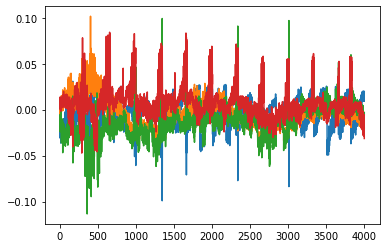

In [6]:
S_estimated = ICA(X_nl.T, lag=50)
plt.plot(S_estimated.T);

In [7]:
previous_loss = torch.zeros(X.size(0)).to(device)
results= []

for _ in range(20):
    mixture = FlowModel(D, NN, 10).to(device)
    X_nl = mixture.to_embedding(S, previous_loss)[0].cpu().detach().numpy()
    S_estimated = ICA(X_nl.T, lag=50)
    results.append(np.abs(np.corrcoef(S.detach().numpy().T, S_estimated)[4:, :-4]).max(1).mean())
    
print(np.mean(results), np.std(results))

0.5945193661400662 0.0795536704448868


### Resolution with slow-FBM

In [9]:
class FlowModel(LayerList, nn.Module):
    def __init__(self, D, NN, depth=1):
        super(FlowModel, self).__init__()
        self.D = D
        self.depth = depth
        
        layers = []
        for d in range(depth):
            shuffled_layer = Shuffle(D)
            layers.append(shuffled_layer)
            layers.append(ActivationNormalization(D))
            layers.append(AffineCoupling(D, NN(), volume_preservation=False))
            layers.append(shuffled_layer)
            layers.append(ActivationNormalization(D))
            layers.append(AffineCoupling(D, NN(), volume_preservation=False))
        
        layers.append(Linear(D))
        # layers.append(Prior(Variable(torch.zeros(1, D)), Variable(torch.zeros(1, D))))
        self.layers = nn.ModuleList(layers)

In [10]:
D = 4

NN = lambda: nn.Sequential(nn.Linear(D//2, 16), nn.LeakyReLU(), 
                           # nn.Linear(64, 64), nn.LeakyReLU(), 
                           nn.Linear(16, D))

flowModel = FlowModel(D, NN, 12)
flowModel.scales = nn.ParameterList([nn.Parameter(torch.ones(D), requires_grad=(i!=0)) for i in range(2)])
flowModel = flowModel.to(device)
optimizer = torch.optim.Adam(list(flowModel.parameters()), lr=1e-3)

In [11]:
X_nl = torch.FloatTensor(X_nl).to(device)
previous_loss = torch.zeros(X_nl.size(0)).to(device)
index = np.arange(X_nl.shape[0])

In [12]:
from torch.distributions.multivariate_normal import MultivariateNormal

for t in range(1500):
    
    optimizer.zero_grad()
    
    index = index[::-1]
    
    x = X_nl[list(index)]
    
    previous_loss = torch.zeros(x.size(0)).to(device)
    z, logprob = flowModel.to_embedding(x, previous_loss)
    
    loss = -logprob.mean()
    
    for i, s in enumerate(flowModel.scales):
        s = s**2
        m = MultivariateNormal(torch.zeros(1, D).to(device), torch.diag(s))
        if i == 0:
            z_lag = z
        else:
            z_lag = z[i:] - z[:-i]
        loss -= m.log_prob(z_lag).mean()
        
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        flowModel.layers[-1].W.div_(torch.norm(flowModel.layers[-1].W))
    
    if t % 10 == 0:
        print('iter %s:' % t, 'loss = %.3f' % loss)

iter 0: loss = 10.439
iter 10: loss = 16.603
iter 20: loss = 15.264
iter 30: loss = 14.328
iter 40: loss = 13.557
iter 50: loss = 12.886
iter 60: loss = 12.335
iter 70: loss = 11.841
iter 80: loss = 11.410
iter 90: loss = 11.061
iter 100: loss = 10.776
iter 110: loss = 10.529
iter 120: loss = 10.317
iter 130: loss = 10.118
iter 140: loss = 10.006
iter 150: loss = 9.793
iter 160: loss = 9.631
iter 170: loss = 9.501
iter 180: loss = 9.355
iter 190: loss = 9.213
iter 200: loss = 9.090
iter 210: loss = 8.992
iter 220: loss = 8.865
iter 230: loss = 8.773
iter 240: loss = 8.668
iter 250: loss = 8.624
iter 260: loss = 8.494
iter 270: loss = 8.402
iter 280: loss = 8.323
iter 290: loss = 8.241
iter 300: loss = 8.162
iter 310: loss = 8.074
iter 320: loss = 7.999
iter 330: loss = 7.929
iter 340: loss = 7.862
iter 350: loss = 7.851
iter 360: loss = 7.739
iter 370: loss = 7.673
iter 380: loss = 7.607
iter 390: loss = 7.540
iter 400: loss = 7.477
iter 410: loss = 7.468
iter 420: loss = 7.424
iter 43

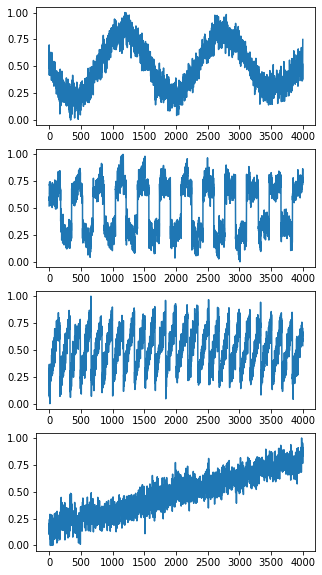

In [13]:
z, logprob = flowModel.to_embedding(X_nl, previous_loss)
S_estimated = ICA(z.detach().numpy().T, lag=100)

m = S_estimated.min(1, keepdims=True)
M = S_estimated.max(1, keepdims=True)
S_estimated = ((S_estimated - m) / (M - m)).T

max_cor = np.argmax(np.abs(np.corrcoef(S.detach().numpy().T, S_estimated.T)[4:, :-4]), axis=0)

plt.figure(figsize=(5, 10))
for i in range(D):
    plt.subplot(4, 1, i+1)
    plt.plot(S_estimated[:, max_cor[i]])

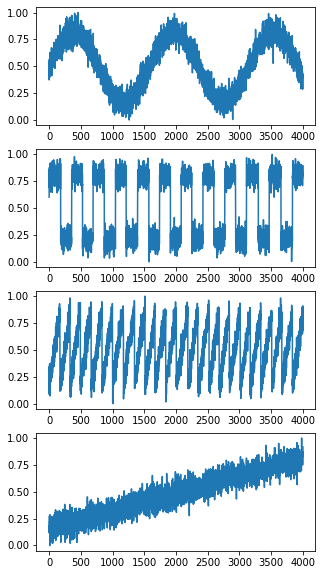

In [14]:
plt.figure(figsize=(5, 10))
for i in range(D):
    plt.subplot(4, 1, i+1)
    plt.plot(S[:, i])

In [15]:
np.corrcoef(S.detach().numpy().T, S_estimated.T)[4:, :-4]

array([[ 6.32162210e-02, -2.50592585e-02,  2.40015306e-02,
         9.79704625e-01],
       [-7.91685104e-03,  9.53055425e-01,  4.06927393e-02,
         3.18826870e-02],
       [-9.69351124e-01,  1.79242345e-02, -7.50685860e-04,
         7.85040935e-02],
       [ 1.05281875e-02,  1.12006922e-02,  9.56558249e-01,
         1.45655323e-02]])

In [16]:
np.abs(np.corrcoef(S.detach().numpy().T, S_estimated.T)[4:, :-4]).max(1).mean()

0.9646673558063042

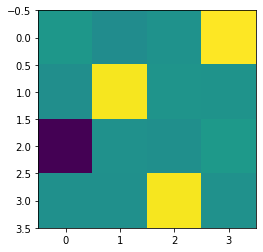

In [17]:
plt.imshow(np.corrcoef(S.detach().numpy().T, S_estimated.T)[4:, :-4])